<a href="https://colab.research.google.com/github/musicjae/Img_projects/blob/main/InceptionV4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### TIP

- 상단에서 <런타임> 클릭 / 런타임 유형 변경 / GPU 선택  
- 코랩은 일정 시간이 지나면 런타임이 중단된다. 그러면 임시 저장된 학습되었던 것, 실행되었던 것 등이 사라진다. 이것을 방지하기 위해, "코랩 연결 끊김 방지"를 실행한다.  
  - F12 누름 / Console 창에서 아래 코드를 붙여 넣고 엔터:  
    -  function ClickConnect(){
    console.log("코랩 연결 끊김 방지"); 
    document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect, 60 * 1000)


## 0 유틸 도구  
  
- 코랩 폴더 내의 데이터 개수 확인 함수

In [37]:
import cv2
from pathlib import Path
path=Path("/content/drive/MyDrive/dataset/img_classfication/animal faces/test/")
#path=path.glob("*.jpg")
images=[]
cnt = 0
for imagepath in path.glob('*.jpg'):
    cnt += 1

print(cnt)    

0


### 0.2 구글 드라이브 연동

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 0.6 임포트

In [180]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from PIL import Image
from keras.optimizers import Adam
from keras.applications import InceptionV3
from keras.applications import ResNet50
from keras.applications import vgg19
from keras.applications import xception
from keras.applications import NASNetLarge
from keras.models import load_model
from keras import layers
import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard as K

import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
from keras.utils.vis_utils import plot_model

## Dataset


- target_size:   
  - (299,299) 사용은 inception V3 에서 최상단 레이어 연결하는 경우: include_top = True 인 경우  
  
  - (200,200) 사용은 False 인 경우에 사용. 다른 shape으로 바꿔 사용해도 됨

In [152]:
train = ImageDataGenerator(rescale = 1/255,validation_split=0.2)

train_dataset = train.flow_from_directory('/content/drive/MyDrive/dataset/img_classfication/animal faces/animal/annotation-tool/Images',
                                          target_size = (200,200),
                                          batch_size = 32,
                                          shuffle=True,
                                          class_mode='categorical',
                                          subset='training') 

val_dataset = train.flow_from_directory('/content/drive/MyDrive/dataset/img_classfication/animal faces/animal/annotation-tool/Images',
                                          target_size = (200,200),
                                          batch_size = 32,
                                          shuffle=False,
                                          class_mode='categorical',
                                          subset='validation') 


Found 7731 images belonging to 7 classes.
Found 1929 images belonging to 7 classes.


In [ ]:
num = 0
for data, labels in val_dataset:
    print(data.shape, labels.shape)
    #print(labels, "<--Labels")
    print()
    num = num + 1
    if num > 5: break

(32, 299, 299, 3) (32, 7)

(32, 299, 299, 3) (32, 7)

(32, 299, 299, 3) (32, 7)

(32, 299, 299, 3) (32, 7)

(32, 299, 299, 3) (32, 7)

(32, 299, 299, 3) (32, 7)



In [ ]:
train_dataset.class_indices

{'001': 0, '002': 1, '003': 2, '005': 3, '006': 4, '007': 5, '008': 6}

## Inception V3  
  
- 텐서플로우를 백엔드로 사용하는 고수준 언어 케라스에서 제공하는 API를 전이학습 모델로 사용: Inception V3  
  
- 최하단 레이어는 출력되는 클래스의 개수에 맞춰주면 된다  
  - 보통 다중 분류인 경우에 "활성화 함수"로 softmax를 사용  
  - 보통 이진 분류인 경우에, 이 함수를 sigmoid로 사용

In [41]:
Inceptionv3 = InceptionV3(include_top=False,weights='imagenet',input_shape=(200,200,3)) # 구글에서 만든 우승 모델. 여러 모델 중 이번 task에서 가장 우수한 성능을 보이고, API로 제공되어 편리하게 사용할 수 있다.
#Inceptionv3 = InceptionV3(include_top=True,weights='imagenet')
inputx = Inceptionv3.output # param num= 2048

flatten_layer = layers.Flatten() # 3차원 이상의 데이터를 2차원으로 평탄화flattening 시켜주기
x = flatten_layer(inputx)

#x = keras.activations.elu(x) 
prediction = keras.layers.Dense(7,activation='softmax')(x) # 최하단을 분류 개수에 맞추기. (예) 12 동물 분류인 경우에, Dense(12, activation='softmax')(x)

model =keras.Model(Inceptionv3.input, prediction)

model.compile(loss="categorical_crossentropy" , optimizer= keras.optimizers.Adam(lr=1e-4), metrics=['accuracy']) # 모델 학습 시 어떤 것들을 사용할지 정함


In [153]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_788 (Conv2D)             (None, 149, 149, 32) 896         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_789 (Conv2D)             (None, 147, 147, 32) 9248        conv2d_788[0][0]                 
__________________________________________________________________________________________________
conv2d_790 (Conv2D)             (None, 147, 147, 64) 18496       conv2d_789[0][0]                 
____________________________________________________________________________________________

In [42]:
es = EarlyStopping(monitor='val_loss',patience=10,verbose=1,mode='min') # 조기종료: 일정 조건을 만족하면 epochs이 다 차지 않아도 조기 종료

history = model.fit(train_dataset,
                    validation_data = val_dataset, 
                      steps_per_epoch = 16,
                      epochs= 100,
                      callbacks=[es]) # 모델 학습

model.save('/content/drive/MyDrive/models/12 animals/test_inceptionv3.h5') # 모델 저장

Epoch 1/100
16/16 [==============================] - 129s 8s/step - loss: 1.3344 - accuracy: 0.5564 - val_loss: 0.7219 - val_accuracy: 0.8134
Epoch 2/100
16/16 [==============================] - 111s 7s/step - loss: 0.5220 - accuracy: 0.7970 - val_loss: 0.3390 - val_accuracy: 0.9191
Epoch 3/100
16/16 [==============================] - 104s 6s/step - loss: 0.3701 - accuracy: 0.8587 - val_loss: 0.3246 - val_accuracy: 0.9139
Epoch 4/100
16/16 [==============================] - 99s 6s/step - loss: 0.2601 - accuracy: 0.9356 - val_loss: 0.3287 - val_accuracy: 0.9176
Epoch 5/100
16/16 [==============================] - 96s 6s/step - loss: 0.2687 - accuracy: 0.9142 - val_loss: 0.2614 - val_accuracy: 0.9331
Epoch 6/100
16/16 [==============================] - 82s 5s/step - loss: 0.1866 - accuracy: 0.9375 - val_loss: 0.2041 - val_accuracy: 0.9440
Epoch 7/100
16/16 [==============================] - 81s 5s/step - loss: 0.1623 - accuracy: 0.9524 - val_loss: 0.2350 - val_accuracy: 0.9316
Epoch 8/10

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


16/16 [==============================] - 66s 4s/step - loss: 0.1142 - accuracy: 0.9612 - val_loss: 0.1911 - val_accuracy: 0.9373
Epoch 12/100
16/16 [==============================] - 57s 4s/step - loss: 0.1002 - accuracy: 0.9771 - val_loss: 0.1761 - val_accuracy: 0.9461
Epoch 13/100
16/16 [==============================] - 58s 4s/step - loss: 0.1065 - accuracy: 0.9655 - val_loss: 0.1703 - val_accuracy: 0.9533
Epoch 14/100
16/16 [==============================] - 60s 4s/step - loss: 0.1748 - accuracy: 0.9587 - val_loss: 0.1811 - val_accuracy: 0.9471
Epoch 15/100
16/16 [==============================] - 56s 4s/step - loss: 0.1251 - accuracy: 0.9563 - val_loss: 0.1744 - val_accuracy: 0.9482
Epoch 16/100
16/16 [==============================] - 49s 3s/step - loss: 0.0966 - accuracy: 0.9743 - val_loss: 0.1899 - val_accuracy: 0.9450
Epoch 17/100
16/16 [==============================] - 49s 3s/step - loss: 0.1058 - accuracy: 0.9640 - val_loss: 0.1708 - val_accuracy: 0.9487
Epoch 18/100
16/16 

## 학습 과정 확인하기

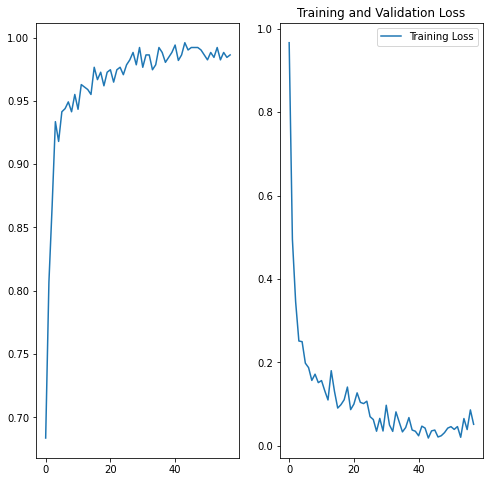

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Custom Inception V4  
  
참고: Szegedy, Christian, et al. "Inception-v4, inception-resnet and the impact of residual connections on learning." Proceedings of the AAAI Conference on Artificial Intelligence. Vol. 31. No. 1. 2017.   


- 참고 사항:
  

    - padding : 경계 처리 방법을 정의합니다.
    -‘valid’ : 유효한 영역만 출력이 됩니다. 따라서 출력 이미지 사이즈는 입력 사이즈보다 작습니다.
    - ‘same’ : 출력 이미지 사이즈가 입력 이미지 사이즈와 동일합니다.


#### stem

In [185]:

def stem(input):
    x = layers.Conv2D(32, kernel_size=(3,3), strides=2,padding='valid')(inputs)
    x = layers.Conv2D(32, kernel_size=(3,3), padding='valid')(x)
    x = layers.Conv2D(64, kernel_size=(3,3),padding='same')(x)
    branch_1a = layers.Conv2D(96, kernel_size=(3,3), strides=2, padding='valid')(x)
    branch_1b = layers.MaxPool2D(pool_size=(3,3),strides=2, padding='valid')(x)

    x = layers.concatenate([branch_1a, branch_1b],axis=-1)

    branch_2a = layers.Conv2D(64, kernel_size=(1,1),padding='same')(x)
    print('2a_0:  ',branch_2a.shape)
    branch_2a = layers.Conv2D(64, kernel_size=(7,1),padding='same')(branch_2a)
    print('2a_1:  ',branch_2a.shape)
    branch_2a = layers.Conv2D(64, kernel_size=(1,7),padding='same')(branch_2a)
    print('2a_2:  ',branch_2a.shape)
    branch_2a = layers.Conv2D(96, kernel_size=(3,3), padding='valid')(branch_2a)
    print('2a_3:  ',branch_2a.shape)
    branch_2b = layers.Conv2D(64, kernel_size=(1,1),padding='same')(x)
    print('2b_1:  ',branch_2b.shape)
    branch_2b = layers.Conv2D(96,kernel_size=(3,3), padding='valid')(branch_2b)
    print('2b_2:  ',branch_2b.shape)

    x = layers.concatenate([branch_2a,branch_2b],axis=-1)
    print(x.shape)

    branch_3a = layers.Conv2D(192, kernel_size=(2,2), padding='valid')(x) # modified
    print('3a_1:  ',branch_3a.shape)
    branch_3b = layers.MaxPool2D(pool_size=(2,2), strides=1,padding='valid')(x) # modified
    print('3b_1:  ',branch_3b.shape)
    x = layers.concatenate([branch_3a,branch_3b],axis=-1)
    print(x.shape)
    #Inception A * 4

    branch_4a = layers.AveragePooling2D(pool_size=(1,1),padding='same')(x)
    branch_4a = layers.Conv2D(96,kernel_size=(1,1),padding='same')(branch_4a)
    print('4a_1:  ',branch_4a.shape)
    branch_4b = layers.Conv2D(96,kernel_size=(1,1),padding='same')(x)
    print('4b_1:  ',branch_4b.shape)
    branch_4c = layers.Conv2D(64,kernel_size=(1,1),padding='same')(x)
    branch_4c = layers.Conv2D(96,kernel_size=(3,3),padding='same')(branch_4c)
    print('4c_1:  ',branch_4c.shape)
    branch_4d = layers.Conv2D(64,kernel_size=(1,1),padding='same')(x)
    branch_4d = layers.Conv2D(96,kernel_size=(3,3),padding='same')(branch_4d)
    branch_4d = layers.Conv2D(96,kernel_size=(3,3),padding='same')(branch_4d)
    print('4d_1:  ',branch_4d.shape)

    outputs = layers.concatenate([branch_4a,branch_4b,branch_4c,branch_4d],axis=-1)

    return outputs

#### Inception_A

In [186]:

def inception_A(x):
    #Inception A * 4

    branch_4a = layers.AveragePooling2D(pool_size=(1,1),padding='same')(x)
    branch_4a = layers.Conv2D(96,kernel_size=(1,1),padding='same')(branch_4a)
    print('4a_1:  ',branch_4a.shape)
    branch_4b = layers.Conv2D(96,kernel_size=(1,1),padding='same')(x)
    print('4b_1:  ',branch_4b.shape)
    branch_4c = layers.Conv2D(64,kernel_size=(1,1),padding='same')(x)
    branch_4c = layers.Conv2D(96,kernel_size=(3,3),padding='same')(branch_4c)
    print('4c_1:  ',branch_4c.shape)
    branch_4d = layers.Conv2D(64,kernel_size=(1,1),padding='same')(x)
    branch_4d = layers.Conv2D(96,kernel_size=(3,3),padding='same')(branch_4d)
    branch_4d = layers.Conv2D(96,kernel_size=(3,3),padding='same')(branch_4d)
    print('4d_1:  ',branch_4d.shape)
    x = layers.concatenate([branch_4a,branch_4b,branch_4c,branch_4d],axis=-1)
    print(f'\nFinal Output Size: {x.shape}')

    return x


#### reduction_A

In [187]:

def reduction_A(input):

    branch_a = layers.MaxPool2D(pool_size=(3,3),strides=2,padding='valid')(input)
    branch_b = layers.Conv2D(384,kernel_size=(3,3),strides=2,padding='valid')(input)
    branch_c = layers.Conv2D(192, kernel_size=(1,1),padding='same')(input)
    branch_c = layers.Conv2D(224, kernel_size=(3,3),padding='same')(branch_c)
    branch_c = layers.Conv2D(256, kernel_size=(3,3), strides=2,padding='valid')(branch_c)

    output = layers.concatenate([branch_a,branch_b,branch_c],axis=-1)

    return output

#### Inception_B

In [188]:

def inception_B(x):
    #Inception B * 7

    branch_4a = layers.AveragePooling2D(pool_size=(1,1),padding='same')(x)
    branch_4a = layers.Conv2D(128,kernel_size=(1,1),padding='same')(branch_4a)
    print('4a_1:  ',branch_4a.shape)
    branch_4b = layers.Conv2D(384,kernel_size=(1,1),padding='same')(x)
    print('4b_1:  ',branch_4b.shape)
    branch_4c = layers.Conv2D(192,kernel_size=(1,1),padding='same')(x)
    branch_4c = layers.Conv2D(224,kernel_size=(1,7),padding='same')(branch_4c)
    branch_4c = layers.Conv2D(256,kernel_size=(1,7),padding='same')(branch_4c)
    print('4c_1:  ',branch_4c.shape)
    branch_4d = layers.Conv2D(192,kernel_size=(1,1),padding='same')(x)
    branch_4d = layers.Conv2D(192,kernel_size=(1,7),padding='same')(branch_4d)
    branch_4d = layers.Conv2D(224,kernel_size=(7,1),padding='same')(branch_4d)
    branch_4d = layers.Conv2D(224,kernel_size=(1,7),padding='same')(branch_4d)
    branch_4d = layers.Conv2D(256,kernel_size=(7,1),padding='same')(branch_4d)
    print('4d_1:  ',branch_4d.shape)
    x = layers.concatenate([branch_4a,branch_4b,branch_4c,branch_4d],axis=-1)
    print(f'\nFinal Output Size: {x.shape}')

    return x


#### Reduction_B

In [189]:

def reduction_B(input):

    branch_a = layers.MaxPool2D(pool_size=(3,3),strides=2,padding='valid')(input)

    branch_b = layers.Conv2D(256,kernel_size=(1,1),padding='same')(input) 
    branch_b = layers.Conv2D(384,kernel_size=(3,3),strides=2,padding='valid')(branch_b)

    branch_c = layers.Conv2D(256, kernel_size=(1,1),padding='same')(input)
    branch_c = layers.Conv2D(256, kernel_size=(3,3),padding='same')(branch_c)
    branch_c = layers.Conv2D(256, kernel_size=(3,3), strides=2,padding='valid')(branch_c)

    output = layers.concatenate([branch_a,branch_b,branch_c],axis=-1)

    return output

#### Inception_C

In [190]:

def inception_C(x):
    #Inception C * 3

    branch_4a = layers.AveragePooling2D(pool_size=(1,1),padding='same')(x)
    branch_4a = layers.Conv2D(256,kernel_size=(1,1),padding='same')(branch_4a)
    print('4a_1:  ',branch_4a.shape)

    branch_4b = layers.Conv2D(256,kernel_size=(1,1),padding='same')(x)
    print('4b_1:  ',branch_4b.shape)

    branch_4c = layers.Conv2D(384,kernel_size=(1,1),padding='same')(x)
    branch_4c_a = layers.Conv2D(256,kernel_size=(1,3),padding='same')(branch_4c)
    branch_4c_b = layers.Conv2D(256,kernel_size=(3,1),padding='same')(branch_4c)
    print('4c_1:  ',branch_4c.shape)

    branch_4d = layers.Conv2D(384,kernel_size=(1,1),padding='same')(x)
    branch_4d = layers.Conv2D(448,kernel_size=(1,3),padding='same')(branch_4d)
    branch_4d = layers.Conv2D(512,kernel_size=(3,1),padding='same')(branch_4d)
    branch_4d_a = layers.Conv2D(256,kernel_size=(3,1),padding='same')(branch_4d)
    branch_4d_b = layers.Conv2D(256,kernel_size=(1,3),padding='same')(branch_4d)
    print('4d_1:  ',branch_4d.shape)

    x = layers.concatenate([branch_4a,branch_4b,branch_4c_a,branch_4c_b,branch_4d_a,branch_4d_b],axis=-1)
    print(f'\nFinal Output Size: {x.shape}')

    return x


#### main_model

In [191]:
inputs = keras.Input(shape=(200,200,3),dtype='float32') # https://sike6054.github.io/blog/paper/fourth-post/

# ==== stem ==== #

outputs = stem(inputs)

# ===== inception_A * 4 ===== #
outputs = inception_A(outputs)
outputs = inception_A(outputs)
outputs = inception_A(outputs)
outputs = inception_A(outputs)

# ===== reduction_A ===== #
outputs = reduction_A(outputs)

# ===== inception_B * 7  ====== #

outputs = inception_B(outputs)
outputs = inception_B(outputs)
outputs = inception_B(outputs)
outputs = inception_B(outputs)
outputs = inception_B(outputs)
outputs = inception_B(outputs)
outputs = inception_B(outputs)


# ===== reduction_B ===== #

outputs = reduction_B(outputs)

# ===== inception_C*3 ====== #

outputs = inception_C(outputs)
outputs = inception_C(outputs)
outputs = inception_C(outputs)


# ===== Finishing ===== #
outputs = layers.AveragePooling2D(pool_size=(1,1),padding='same')(outputs)
outputs = layers.Dropout(0.3)(outputs)

# ==== tuning  === # 
flatten_layer = layers.Flatten() # 3차원 이상의 데이터를 2차원으로 평탄화flattening 시켜주기
outputs = flatten_layer(outputs)

x = layers.Dropout(0.2)(keras.activations.elu(x))
x = layers.Dense(1024)(x)
x = layers.Dropout(0.2)(keras.activations.elu(x))
x = layers.Dense(256)(x)
x = layers.Dropout(0.2)(keras.activations.elu(x))
x = layers.Dense(64)(x)
x = layers.Dropout(0.2)(keras.activations.elu(x))

prediction = keras.layers.Dense(7,activation='softmax')(outputs) 


inceptionv4 = keras.models.Model(inputs, prediction)
inceptionv4.summary()

2a_0:   (None, 48, 48, 64)
2a_1:   (None, 48, 48, 64)
2a_2:   (None, 48, 48, 64)
2a_3:   (None, 46, 46, 96)
2b_1:   (None, 48, 48, 64)
2b_2:   (None, 46, 46, 96)
(None, 46, 46, 192)
3a_1:   (None, 45, 45, 192)
3b_1:   (None, 45, 45, 192)
(None, 45, 45, 384)
4a_1:   (None, 45, 45, 96)
4b_1:   (None, 45, 45, 96)
4c_1:   (None, 45, 45, 96)
4d_1:   (None, 45, 45, 96)
4a_1:   (None, 45, 45, 96)
4b_1:   (None, 45, 45, 96)
4c_1:   (None, 45, 45, 96)
4d_1:   (None, 45, 45, 96)

Final Output Size: (None, 45, 45, 384)
4a_1:   (None, 45, 45, 96)
4b_1:   (None, 45, 45, 96)
4c_1:   (None, 45, 45, 96)
4d_1:   (None, 45, 45, 96)

Final Output Size: (None, 45, 45, 384)
4a_1:   (None, 45, 45, 96)
4b_1:   (None, 45, 45, 96)
4c_1:   (None, 45, 45, 96)
4d_1:   (None, 45, 45, 96)

Final Output Size: (None, 45, 45, 384)
4a_1:   (None, 45, 45, 96)
4b_1:   (None, 45, 45, 96)
4c_1:   (None, 45, 45, 96)
4d_1:   (None, 45, 45, 96)

Final Output Size: (None, 45, 45, 384)
4a_1:   (None, 22, 22, 128)
4b_1:   (None,

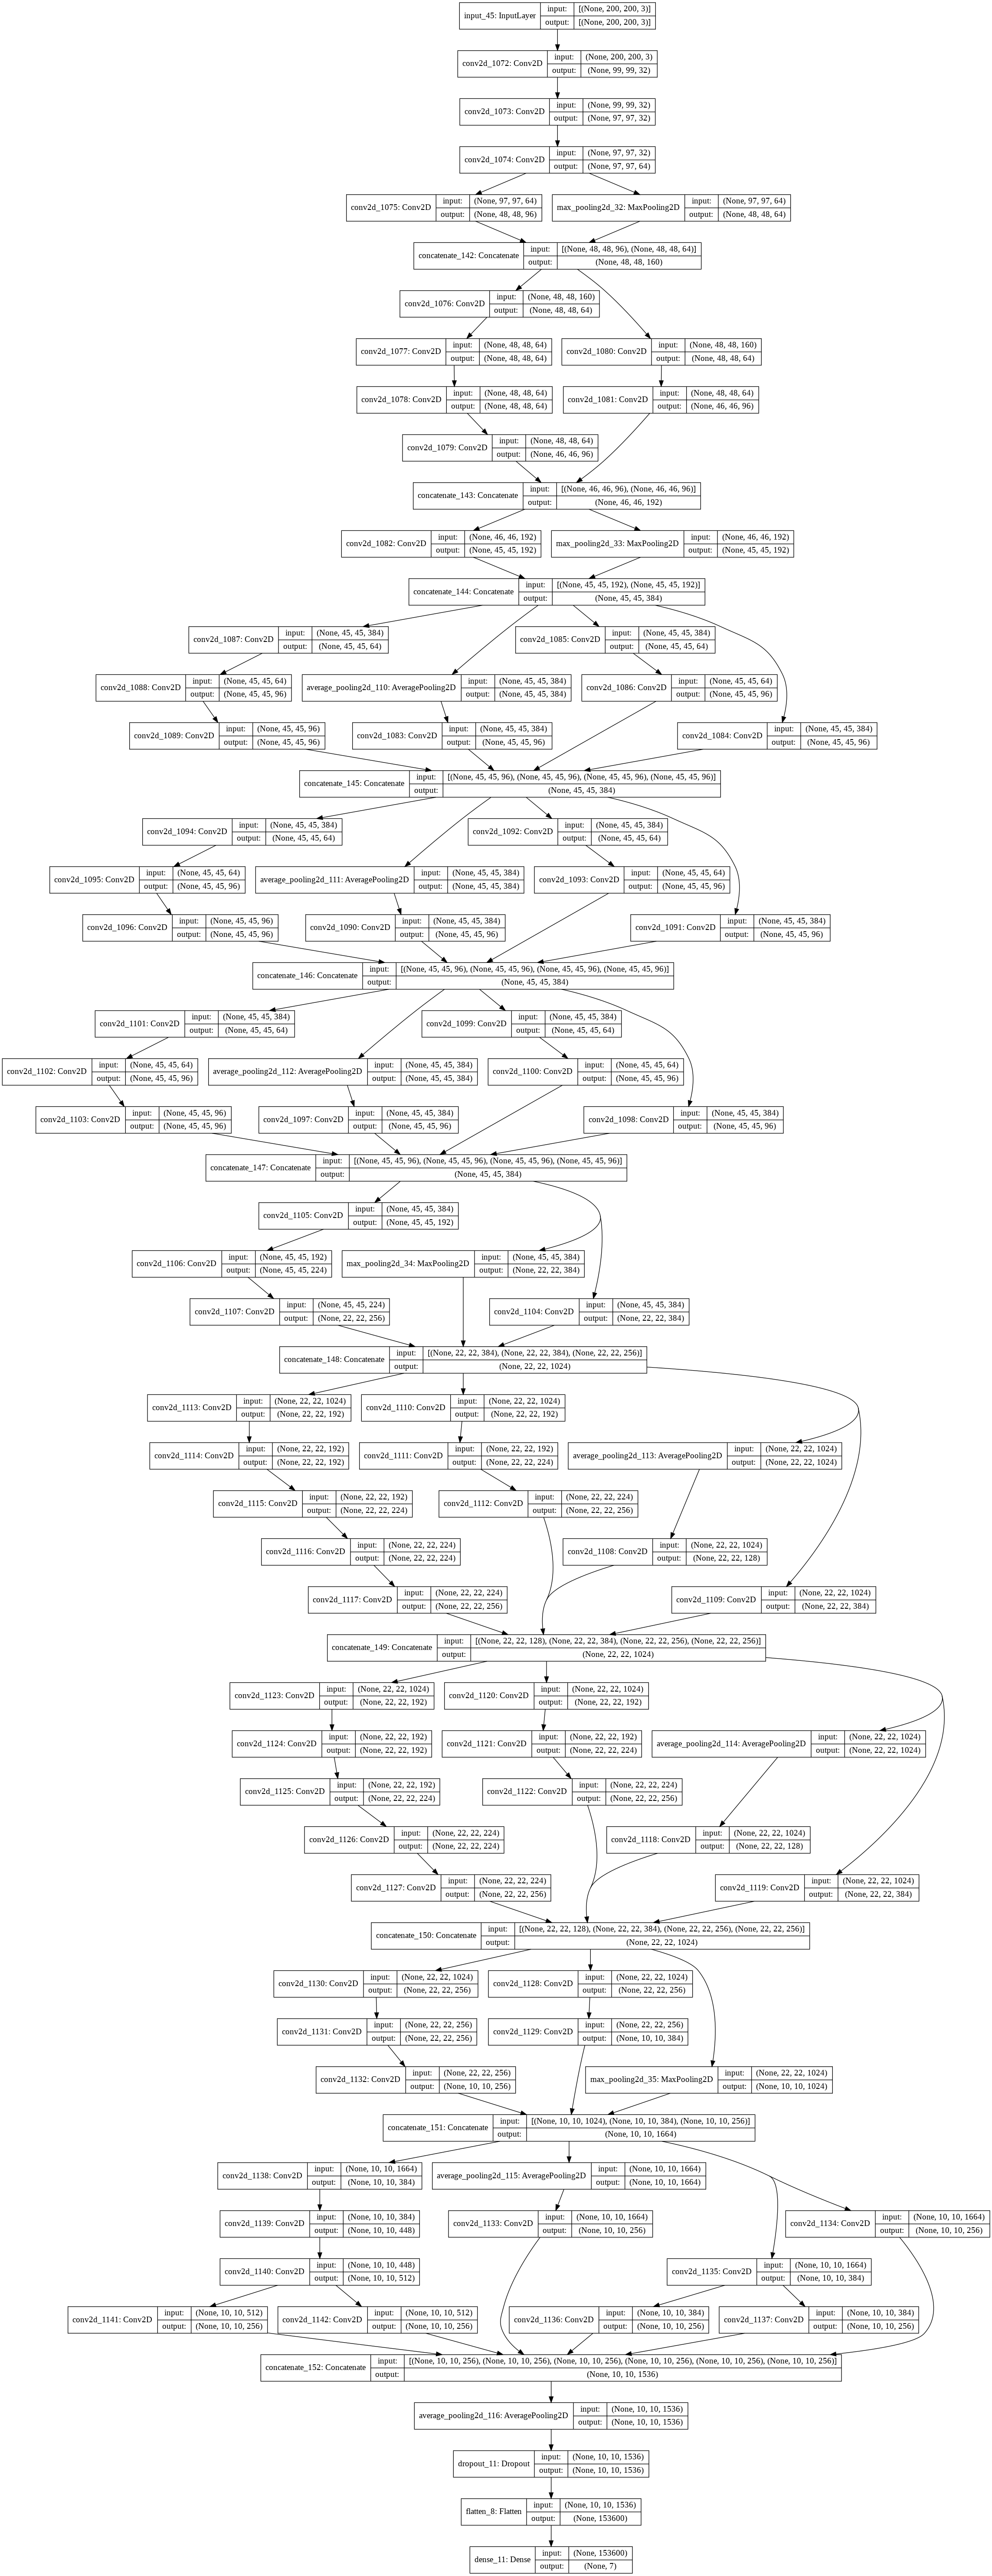

In [183]:
plot_model(inceptionv4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Training

- RMSProp: 여기서 rho 가 decay. 원문의 실험에서는 RMSPROP에서 decay(rho) = 0.94,  lr = 0.045를 사용 ==> 하지만 우리 실험에서 이 값은 별로임을 확인

In [193]:
inceptionv4.compile(loss="categorical_crossentropy" , optimizer= keras.optimizers.RMSprop(learning_rate=0.001,rho=0.93), metrics=['accuracy']) # 모델 학습 시 어떤 것들을 사용할지 정함
es = EarlyStopping(monitor='val_loss',patience=10,verbose=1,mode='min') # 조기종료: 일정 조건을 만족하면 epochs이 다 차지 않아도 조기 종료

v4_history = inceptionv4.fit(train_dataset,
                    validation_data = val_dataset, 
                      steps_per_epoch = 16,
                      epochs= 100,
                      callbacks=[es]) # 모델 학습

RuntimeError: ignored

## 학습 과정 확인하기

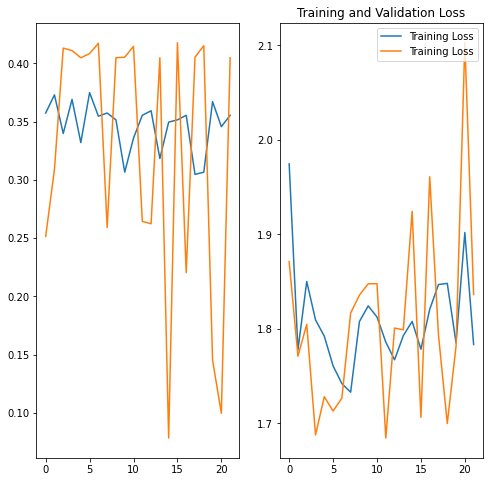

In [120]:
acc = v4_history.history['accuracy']
acc_val = v4_history.history['val_accuracy']
loss=v4_history.history['loss']
loss_val=v4_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc,acc_val, label='Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, loss_val,label='Training Loss')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 실행

In [67]:
## load model
use_model = keras.models.load_model('/content/drive/MyDrive/models/12 animals/test_inceptionv3.h5')
use_img = keras.preprocessing.image.load_img('/content/drive/MyDrive/dataset/img_classfication/animal faces/KakaoTalk_20201222_125316359.jpg',target_size=(200,200))

In [54]:
def img_preprocess(img):
    img = img.convert('RGB').resize((200,200))
    img = np.array(img)

    img = img.reshape((200,200,3))
    plt.imshow(img)
    
    img= [img]
    img = np.array(img)
    img = img/255

    return img

In [63]:
animal_class = {'개':0,'소':1,'호랑이':2,'닭':3,'말':4,'원숭이':5,'토끼':6}

4


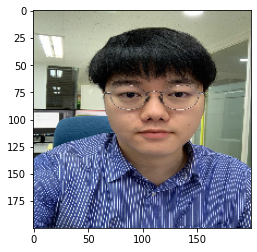

In [68]:
pred = use_model.predict(img_preprocess(use_img))
pred_i = np.argmax(pred)
print(pred_i)

In [70]:
for key, value in animal_class.items():
    if pred_i == value:
        print(round((np.max(pred)*100),2),'%',f'{key} 상 입니다.\n')

78.11 % 말 상 입니다.

